In [80]:
import matplotlib.pyplot as plt

In [120]:
import numpy as np

class AdaNeuralNet:
    def __init__(self,nodes,indims,activations,
                  actders, cost, task='Classifcation',scaleweights=True, seed=False):
        self.nodes=nodes
        self.layers=len(nodes)
        self.indims=indims
        self.activations=activations
        self.actders=actders
        self.task=task
        self.cost=cost
        self.weights={}
        self.biases={}
        self.Gw={}
        self.Gb={}
        self.y_classes=[]
        self.Xmins=np.array([])
        self.scaleweights=scaleweights
        if seed !=False:
            np.random.seed(seed)

    def weightinit(self):
        self.weights['W0']=np.random.randn(self.indims,self.nodes[0])
        self.biases['B0']=np.random.randn(1,self.nodes[0])
        self.Gw['0']=np.ones((self.indims,self.nodes[0]))
        self.Gb['0']=np.ones((1,self.nodes[0]))
        for i in range(1,self.layers):
            if self.scaleweights:
                self.weights['W'+str(i)]=np.random.randn(self.nodes[i-1],self.nodes[i])*np.sqrt(1/(self.nodes[i-1]+self.nodes[i]))
                self.biases['B'+str(i)]=np.random.randn(1,self.nodes[i])*np.sqrt(1/(self.nodes[i-1]+self.nodes[i]))
            else:
                self.weights['W'+str(i)]=np.random.randn(self.nodes[i-1],self.nodes[i])
                self.biases['B'+str(i)]=np.random.randn(1,self.nodes[i])
            self.Gw[str(i)]=np.zeros((self.nodes[i-1],self.nodes[i]))
            self.Gb[str(i)]=np.zeros((1,self.nodes[i]))

    def get_one_hot(self,targets):
        targets=np.asarray(targets).reshape(-1)
        num_classes=len(np.unique(targets))
        indices=np.searchsorted(np.unique(targets),targets)
        res = np.eye(num_classes)[indices]
        return res.reshape(len(targets),num_classes)

    def mat_ohe(self,data, cols_to_ohe):
        ohe_cols=np.apply_along_axis(self.get_one_hot,0,data[:,cols_to_ohe])[:,:,0]
        data=np.hstack((data,ohe_cols))
        data=np.delete(data,cols_to_ohe,1)
        return data.astype(float)

    def norm(self,X,Xmin,Xmax):
        return (X-Xmin)/(Xmax-Xmin)

    def unnorm(self,X,Xmin,Xmax):
        return (X)*(Xmax-Xmin)+Xmin

    def predict(self, X, normalize=True):
        self.Z={}
        self.Zprime={}


        if not self.Xmins.size:
            self.Xmaxes=X.max(0)
            self.Xmins=X.min(0)
            X=self.norm(X,self.Xmins,self.Xmaxes)
        elif normalize:
            X=self.norm(X,self.Xmins,self.Xmaxes)

        if not self.weights:
            self.weightinit()

        self.Z['Z0']=X

        for i in range(self.layers-1):
            self.Z['Z'+str(i+1)]=self.activations[i](self.Z['Z'+str(i)]@self.weights['W'+str(i)]+\
                  self.biases["B"+str(i)])
            self.Zprime['Zprime'+str(i)]=self.actders[i](self.Z['Z'+str(i)]@self.weights['W'+str(i)]+\
                       self.biases["B"+str(i)])
        if self.task=='Classification':
            #Convert to array in case a matrix was passed
            self.probabilities=np.array(self.activations[self.layers-1](self.Z['Z'+str(self.layers-1)]\
                                        @self.weights['W'+str(self.layers-1)]+\
                                        self.biases["B"+str(self.layers-1)]))
            if self.nodes[-1]>1 and self.y_classes.size:
                 self.predictions=self.y_classes[np.argmax(self.probabilities, axis=1)].reshape(-1,1)
            elif self.nodes[-1]>1:
                self.predictions=np.eye(self.probabilities.shape[1])[np.argmax(self.probabilities, axis=1)]
            else:
                self.predictions=np.where(np.rint(self.probabilities)==1,self.positive_class,self.negative_class).reshape(-1,1)
        elif self.task=='Regression':
            self.normpredictions=self.Z['Z'+str(self.layers-1)]@self.weights['W'+str(self.layers-1)]+\
            self.biases["B"+str(self.layers-1)]

            self.predictions=self.unnorm(self.normpredictions,self.ymins,self.ymaxes)
        else:
            self.predictions="Invalid task. Must use regression or classification.Default is classification"

    def train(self,X,y,epochs,eta,mu=0,decay=False, k=0.9, T=900,X_val=np.array([]),y_val=np.array([])):
        self.valerror=[]
        self.error=[]
        d={}
        self.Xmaxes=X.max(0)
        self.Xmins=X.min(0)
        X=self.norm(X,self.Xmins,self.Xmaxes)
        if X_val.size:
            X_val=self.norm(X_val,self.Xmins,self.Xmaxes)

        if (self.task=="Classification" and y.shape[1]<self.nodes[-1]):
            self.y_classes=np.unique(y)
            y=self.mat_ohe(y,[0])
            if y_val.size:
                y_val=self.mat_ohe(y_val,[0])
        elif (self.task=="Classification" and y.shape[1]==self.nodes[-1]):
            self.positive_class=np.unique(y)[1]
            self.negative_class=np.unique(y)[0]
            y=np.where(y==self.positive_class,1,0)
            if y_val.size:
                y_val=np.where(y_val==self.positive_class,1,0)
        elif self.task=="Regression":
            self.ymaxes=y.max(0)
            self.ymins=y.min(0)
            y=self.norm(y,self.ymins,self.ymaxes)
            if y_val.size:
                y_val=self.norm(y_val,self.ymins,self.ymaxes)
        self.predict(X,False)
        for i in range(epochs):
            if self.task=='Classification':
                d['d'+str(self.layers-1)]=self.probabilities-y
            elif self.task=='Regression':
                d['d'+str(self.layers-1)]=self.normpredictions-y
            else:
                return self.predictions

            for j in range(self.layers-1):
                d['d'+str(self.layers-2-j)]=np.multiply(d['d'+str(self.layers-1-j)]\
                @self.weights['W'+str(self.layers-1-j)].T,\
                self.Zprime['Zprime'+str(self.layers-2-j)])

            for j in range(self.layers):
                self.Gw[str(j)]=self.Gw[str(j)]+(self.Z['Z'+str(j)].T@d['d'+str(j)])**2
                self.Gb[str(j)]=self.Gb[str(j)]+((np.sum(d['d'+str(j)], axis=0)))**2
                
                etaw=eta*np.ones(self.Gw[str(j)].shape)/np.sqrt(self.Gw[str(j)]+1e-9)
                etab=eta*np.ones(self.Gb[str(j)].shape)/np.sqrt(self.Gb[str(j)]+1e-9)
                self.weights['W'+str(j)]=self.weights['W'+str(j)]-etaw*(self.Z['Z'+str(j)].T@d['d'+str(j)])
                
                self.biases['B'+str(j)]=self.biases['B'+str(j)]-etab*(np.sum(d['d'+str(j)], axis=0))

            if decay=="Scheduled":
                eta=eta*k**(i/T)
            elif decay=="Inverse":
                eta=eta/(k*i+1)
            elif decay=="Exponential":
                eta=eta*np.exp(-k*i)


            if self.task=='Classification':
                if y_val.size:
                    self.predict(X_val,False)
                    self.valerror.append(self.cost(y_val,self.probabilities))
                self.predict(X,False)
                self.error.append(self.cost(y,self.probabilities))
            else:
                if y_val.size:
                    self.predict(X_val,False)
                    self.valerror.append(self.cost(y_val,self.normpredictions))
                self.predict(X,False)
                self.error.append(self.cost(y,self.normpredictions))


In [121]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def cost(y,p):
    Err=[]
    zeros=np.where(y==0)
    ones=np.where(y==1)
    Err=np.hstack((-y[ones]*np.log(p[ones]),-(1-y[zeros])*np.log(1-p[zeros])))
    return np.mean(Err)

def dertanh(X):
    return 1-np.power(np.tanh(X),2)

In [122]:
nodes=[20,20,20,1]
activations=[np.tanh]*(len(nodes)-1)+[sigmoid]
act_ders=[dertanh]*(len(nodes)-1)


In [123]:
X1=np.random.randn(1000,2)
X2=np.random.randn(1000,2)+4.5

X1=np.hstack((np.ones((1000,1)),X1))
X2=np.hstack((np.zeros((1000,1)),X2))

X=np.vstack((X1,X2))

np.random.shuffle(X)
y=X[:,:1]
X=X[:,1:]

In [166]:
model=AdaNeuralNet(nodes,X.shape[1],activations,act_ders,cost,task="Classification")

In [195]:
model.train(X,y,10000,0.9)

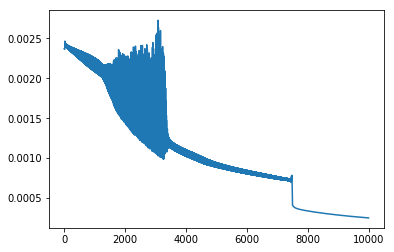

In [196]:
plt.plot(model.error)

In [197]:
(model.predictions==y).mean()

1.0

In [191]:
(np.rint(model.probabilities)==y).mean()

0.998

In [150]:
model.predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [118]:
model.positive_class

1.0

In [119]:
model.negative_class

array([1.])

In [198]:
data=np.random.randn(2000,2)
data2=(25./100.)*np.random.randn(1000,2)
data3=2.3*np.random.randn(3000,2)

circle=np.array([[x[0],x[1]] for x in data if (np.sqrt(x[0]**2+x[1]**2)>2.0)])
circle3=np.array([[x[0],x[1]] for x in data3 if (np.sqrt(x[0]**2+x[1]**2)>5.50)])

data2=np.hstack((data2,np.zeros((data2.shape[0],1))))
data=np.hstack((circle,np.ones((circle.shape[0],1))))
data3=np.hstack((circle3,2*np.ones((circle3.shape[0],1))))


data=data[:300,:]
data2=data2[:300,:]
data3=data3[:300,:]
X=np.vstack((data,data2,data3))
np.random.shuffle(X)
y=X[:,-1:]
X=X[:,:-1]

In [203]:
def softmax(X):
    p=np.exp(X)
    return(p/(p.sum(1).reshape(X.shape[0],1)))

In [204]:
nodes=[20,20,20,3]
activations=[np.tanh]*(len(nodes)-1)+[softmax]
act_ders=[dertanh]*(len(nodes)-1)


In [205]:
model=AdaNeuralNet(nodes,X.shape[1],activations,act_ders,cost,task="Classification")

In [212]:
model.train(X,y,100,9)

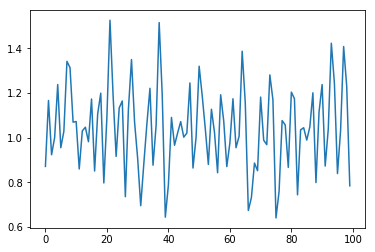

In [213]:
plt.plot(model.error)

In [214]:
model.y_classes

array([0., 1., 2.])

In [215]:
model.probabilities

array([[0.11902043, 0.33439206, 0.54658751],
       [0.11902043, 0.33439206, 0.54658751],
       [0.11902043, 0.33439206, 0.54658751],
       ...,
       [0.11902043, 0.33439206, 0.54658751],
       [0.11902043, 0.33439206, 0.54658751],
       [0.11902043, 0.33439206, 0.54658751]])